In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Setting device to GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Setting device to CPU.")

CUDA is available. Setting device to GPU.


In [3]:

import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk(r'C:\Users\insid\OneDrive\Desktop\Project DL'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\insid\OneDrive\Desktop\Project DL\exp-cnn-lstm.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\exp-lstm.ipynb
C:\Users\insid\OneDrive\Desktop\Project DL\IMDB Dataset.csv


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import pandas as pd


imdb_csv = r'C:\Users\insid\OneDrive\Desktop\Project DL\IMDB Dataset.csv'

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\insid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:


def preprocess_text(text):
    
    tokens = word_tokenize(text.lower())
 
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

def load_imdb_dataset(csv_file):
    df = pd.read_csv(csv_file)
    reviews = []
    for _, row in df.iterrows():
        review = row['review']
        sentiment = 1 if row['sentiment'] == 'positive' else 0
        preprocessed_review = preprocess_text(review)
        reviews.append((preprocessed_review, sentiment))
    return reviews


class IMDBDataset(Dataset):
    def __init__(self, reviews, vocab_size=10000):
        self.reviews = reviews
        self.vocab_size = vocab_size
        self.word_to_idx = self.build_vocab()
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.sequence_length = max(len(review[0].split()) for review in reviews)
        
    def build_vocab(self):
        word_counts = {}
        for review, _ in self.reviews:
            for word in review.split():
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
        
        sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)[:self.vocab_size]
        return {word: idx for idx, word in enumerate(sorted_words)}
    
    def vectorize_review(self, review):
        vector = np.zeros(self.sequence_length, dtype=np.int64)
        for i, word in enumerate(review.split()):
            if i >= self.sequence_length:
                break
            vector[i] = self.word_to_idx.get(word, 0)
        return vector
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, index):
        review, sentiment = self.reviews[index]
        review_vector = self.vectorize_review(review)
        return torch.tensor(review_vector), torch.tensor(sentiment)


class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.fc(hidden)
        return self.sigmoid(out)


In [6]:

vocab_size = 10000
embedding_dim = 200
hidden_dim = 256
output_dim = 1
num_layers = 2
dropout = 0.5
batch_size = 64
num_epochs = 10
learning_rate = 0.001

In [9]:


reviews = load_imdb_dataset(imdb_csv)
from torch.utils.data import Dataset, DataLoader, random_split


dataset = IMDBDataset(reviews, vocab_size)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


dataset_size = len(dataset)
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [8]:


for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target.float())
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(data_loader)}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        predicted = (output.squeeze() >= 0.5).float()
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

Epoch [1/10], Batch [100/782], Loss: 0.6515
Epoch [1/10], Batch [200/782], Loss: 0.6441
Epoch [1/10], Batch [300/782], Loss: 0.5827
Epoch [1/10], Batch [400/782], Loss: 0.6141
Epoch [1/10], Batch [500/782], Loss: 0.6014
Epoch [1/10], Batch [600/782], Loss: 0.4855
Epoch [1/10], Batch [700/782], Loss: 0.4070
Epoch [2/10], Batch [100/782], Loss: 0.4330
Epoch [2/10], Batch [200/782], Loss: 0.2872
Epoch [2/10], Batch [300/782], Loss: 0.2330
Epoch [2/10], Batch [400/782], Loss: 0.2556
Epoch [2/10], Batch [500/782], Loss: 0.3980
Epoch [2/10], Batch [600/782], Loss: 0.3758
Epoch [2/10], Batch [700/782], Loss: 0.3877
Epoch [3/10], Batch [100/782], Loss: 0.4149
Epoch [3/10], Batch [200/782], Loss: 0.1133
Epoch [3/10], Batch [300/782], Loss: 0.2093
Epoch [3/10], Batch [400/782], Loss: 0.1801
Epoch [3/10], Batch [500/782], Loss: 0.1689
Epoch [3/10], Batch [600/782], Loss: 0.3086
Epoch [3/10], Batch [700/782], Loss: 0.1768
Epoch [4/10], Batch [100/782], Loss: 0.2162
Epoch [4/10], Batch [200/782], L

Train Epoch [1/10], Batch [100/547], Loss: 0.5379
Train Epoch [1/10], Batch [200/547], Loss: 0.5668
Train Epoch [1/10], Batch [300/547], Loss: 0.3360
Train Epoch [1/10], Batch [400/547], Loss: 0.3420
Train Epoch [1/10], Batch [500/547], Loss: 0.4034
Validation Loss: 0.3290
Train Epoch [2/10], Batch [100/547], Loss: 0.2371
Train Epoch [2/10], Batch [200/547], Loss: 0.3584
Train Epoch [2/10], Batch [300/547], Loss: 0.1563
Train Epoch [2/10], Batch [400/547], Loss: 0.3999
Train Epoch [2/10], Batch [500/547], Loss: 0.8908
Validation Loss: 0.6406
Train Epoch [3/10], Batch [100/547], Loss: 0.4530
Train Epoch [3/10], Batch [200/547], Loss: 0.3091
Train Epoch [3/10], Batch [300/547], Loss: 0.3673
Train Epoch [3/10], Batch [400/547], Loss: 0.2372
Train Epoch [3/10], Batch [500/547], Loss: 0.3049
Validation Loss: 0.3431
Train Epoch [4/10], Batch [100/547], Loss: 0.2111
Train Epoch [4/10], Batch [200/547], Loss: 0.2534
Train Epoch [4/10], Batch [300/547], Loss: 0.2623
Train Epoch [4/10], Batch [4

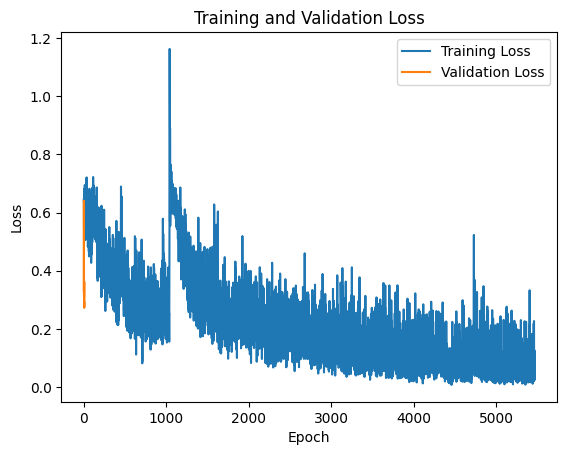

In [11]:
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target.float())
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if (batch_idx + 1) % 100 == 0:
            print(f'Train Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    
    model.eval()  
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output.squeeze(), target.float()).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}')


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        predicted = (output.squeeze() >= 0.5).float()
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [15]:
def predict_sentiment(model, sentence, dataset):
    model.eval()
    
    
    preprocessed_sentence = preprocess_text(sentence)
    
    
    vectorized_sentence = dataset.vectorize_review(preprocessed_sentence)
    vectorized_sentence = torch.tensor(vectorized_sentence).unsqueeze(0).to(device)
    
    
    with torch.no_grad():
        output = model(vectorized_sentence)
        predicted = torch.sigmoid(output).item()
    
    
    sentiment = 'Positive' if predicted >= 0.6 else 'Negative'
    confidence = predicted if predicted >= 0.6 else 1 - predicted
    
    return sentiment, confidence


sentences = [
    "This movie was fantastic! The acting was superb and the plot kept me engaged throughout.",
    "I was really disappointed with this book. The characters were poorly developed and the story was predictable.",
    "The restaurant had great ambiance, but the food was mediocre at best.",
    "I absolutely loved this song! It's catchy and the lyrics are meaningful."
]

for sentence in sentences:
    sentiment, confidence = predict_sentiment(model, sentence, dataset)
    print(f'Sentence: {sentence}')
    print(f'Predicted Sentiment: {sentiment}')
    print(f'Confidence: {confidence:.2f}')
    print('---')

Sentence: This movie was fantastic! The acting was superb and the plot kept me engaged throughout.
Predicted Sentiment: Positive
Confidence: 0.73
---
Sentence: I was really disappointed with this book. The characters were poorly developed and the story was predictable.
Predicted Sentiment: Negative
Confidence: 0.50
---
Sentence: The restaurant had great ambiance, but the food was mediocre at best.
Predicted Sentiment: Negative
Confidence: 0.41
---
Sentence: I absolutely loved this song! It's catchy and the lyrics are meaningful.
Predicted Sentiment: Positive
Confidence: 0.73
---
